In [160]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic
warnings.simplefilter('ignore', ConvergenceWarning)

# --- SET FORECAST MONTHS HERE ---
forecast_steps = 5

# --- CREATE NECESSARY FOLDERS ---
os.makedirs('graphs', exist_ok=True)

# Data Loading and Preparation

In [161]:
def load_prepare_data(file_path):
    """Load and prepare the dataset with proper error handling"""
    try:
        df = pd.read_excel(file_path, sheet_name='Domestic Currency', skiprows=5, header=[0,1])
        india_cols = [col for col in df.columns if col[1] == 'India']
        df_india = df[india_cols].copy()
        df_india['Items'] = df['Items']
        df_india = df_india.set_index('Items').T.reset_index()
        df_india = df_india.rename(columns={'level_0': 'Month', 'level_1': 'Country'})
        df_final = df_india[['Month', 'Country', 'Currency in Circulation']]
        df_final = df_final.iloc[16:].reset_index(drop=True)

        df_rates = pd.read_excel(file_path, sheet_name='Rates & ratio', skiprows=5, header=[0,1])
        india_cols_rate = [col for col in df_rates.columns if col[1] == 'India']
        df_india_rates = df_rates[india_cols_rate].copy()
        df_india_rates['Items'] = df_rates['Items']
        df_india_rates = df_india_rates.set_index('Items').T.reset_index()
        df_india_rates = df_india_rates.rename(columns={'level_0': 'Month', 'level_1': 'Country'})
        df_india_rates.columns = [col.strip() if isinstance(col, str) else col for col in df_india_rates.columns]

        needed_cols = ['Month', 'Country', 'Repo Rate', 'CPI Inflation Rate (in %)']
        df_final_rates = df_india_rates[needed_cols]
        df_final_rates = df_final_rates.iloc[16:].reset_index(drop=True)

        df_merged = pd.merge(df_final, df_final_rates, on=['Month', 'Country'], how='left')

        if len(df_merged) > 156:
            df_merged = df_merged.iloc[:-156]

        for col in ['Currency in Circulation', 'Repo Rate', 'CPI Inflation Rate (in %)']:
            df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce')

        df_merged.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_merged[['Currency in Circulation', 'Repo Rate', 'CPI Inflation Rate (in %)']] = df_merged[['Currency in Circulation', 'Repo Rate', 'CPI Inflation Rate (in %)']].interpolate(method='linear')
        df_merged.fillna(method='bfill', inplace=True)
        df_merged.fillna(method='ffill', inplace=True)

        df_merged['Month'] = pd.to_datetime(df_merged['Month'])
        df_merged = df_merged.sort_values('Month').reset_index(drop=True)
        return df_merged
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Load the data
file_path = './data/Monthly_Series_Economic_Variable.xlsx'
df = load_prepare_data(file_path)
df.head()

/usr/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipykernel_5624/2841865976.py:35: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='bfill', inplace=True)
/tmp/ipykernel_5624/2841865976.py:36: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_merged.fillna(method='ffill', inplace=True)
/tmp/ipykernel_5624/2841865976.py:38: UserWarning: Could not infer format, so each element will be parsed individually, fallin

,Month,Country,Currency in Circulation,Repo Rate,CPI Inflation Rate (in %)
0,2014-01-01,India,1.279164e+07,8.0,8.604207
1,2014-02-01,India,1.291939e+07,8.0,7.882241
2,2014-03-01,India,1.301074e+07,8.0,8.246445
3,2014-04-01,India,1.345088e+07,8.0,8.482564
4,2014-05-01,India,1.365730e+07,8.0,8.325538


# Exploratory Data Analysis

In [162]:
# Summary Statistics
df[['Currency in Circulation', 'Repo Rate', 'CPI Inflation Rate (in %)']].describe()

,Currency in Circulation,Repo Rate,CPI Inflation Rate (in %)
count,1.200000e+02,120.000000,120.000000
mean,2.205321e+07,5.961250,5.247716
std,7.338681e+06,1.242299,1.633844
min,9.432091e+06,4.000000,1.460415
25%,1.544175e+07,5.150000,4.144970
50%,2.047514e+07,6.250000,5.234332
75%,2.944208e+07,6.500000,6.604508
max,3.478479e+07,8.000000,8.604207


In [163]:
# Correlation Matrix
df[['Currency in Circulation', 'Repo Rate', 'CPI Inflation Rate (in %)']].corr()

,Currency in Circulation,Repo Rate,CPI Inflation Rate (in %)
Currency in Circulation,1.000000,-0.625245,0.363794
Repo Rate,-0.625245,1.000000,-0.075146
CPI Inflation Rate (in %),0.363794,-0.075146,1.000000


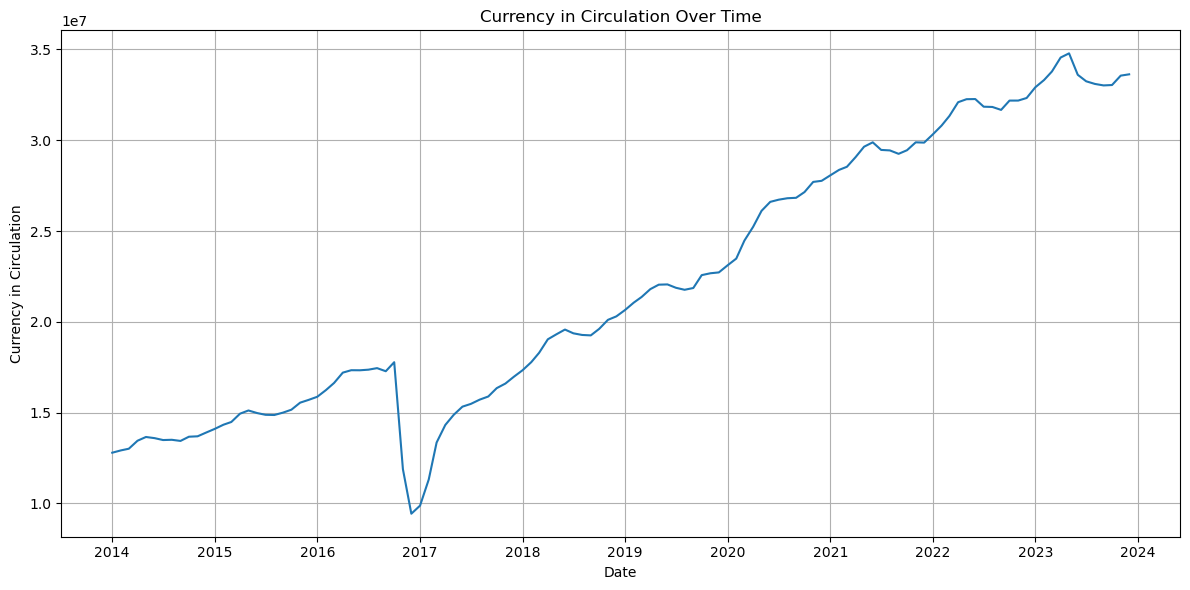

In [164]:
# Time Series Plots
plt.figure(figsize=(12,6))
plt.plot(df['Month'], df['Currency in Circulation'])
plt.title('Currency in Circulation Over Time')
plt.xlabel('Date')
plt.ylabel('Currency in Circulation')
plt.grid()
plt.tight_layout()
plt.show()

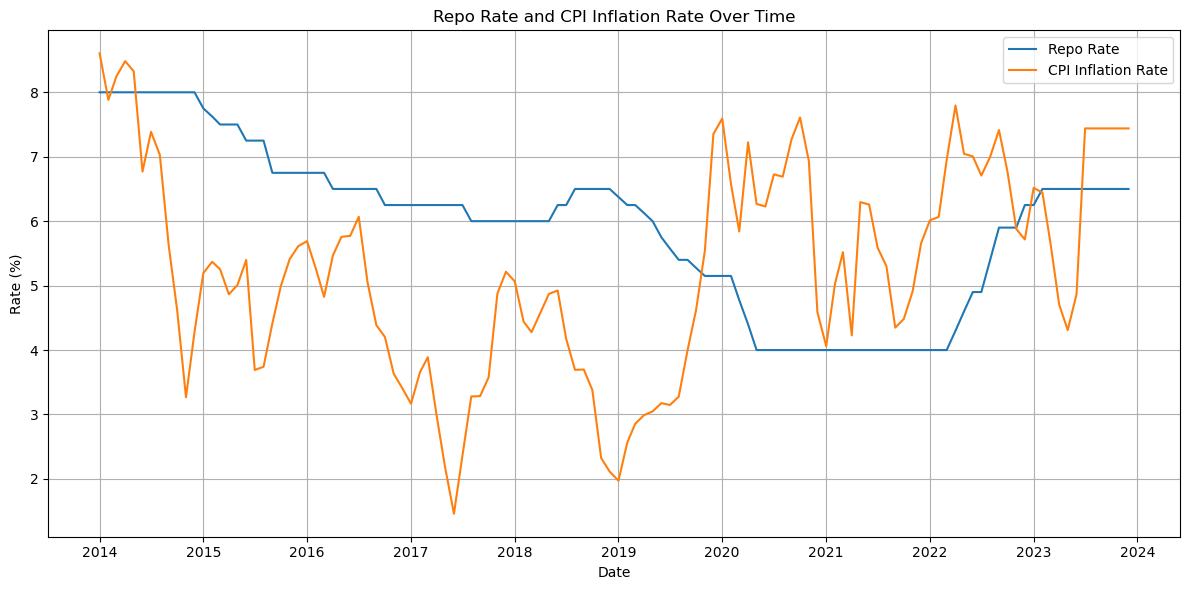

In [165]:
plt.figure(figsize=(12,6))
plt.plot(df['Month'], df['Repo Rate'], label='Repo Rate')
plt.plot(df['Month'], df['CPI Inflation Rate (in %)'], label='CPI Inflation Rate')
plt.title('Repo Rate and CPI Inflation Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Stationarity Analysis

In [166]:
# ADF Test for Currency in Circulation
result = adfuller(df['Currency in Circulation'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -0.3669529638589943
p-value: 0.915471952911812
Critical Values:
	1%: -3.487517288664615
	5%: -2.8865777180380032
	10%: -2.5801239192052012


In [167]:
# Check if differencing is needed
if result[1] > 0.05:
    df['Currency_diff'] = df['Currency in Circulation'].diff()
    series_to_use = df['Currency_diff']
    prefix = 'currency_diff'
    print('Note: Currency in Circulation was non-stationary, using first differences')
else:
    series_to_use = df['Currency in Circulation']
    prefix = 'currency'

Note: Currency in Circulation was non-stationary, using first differences


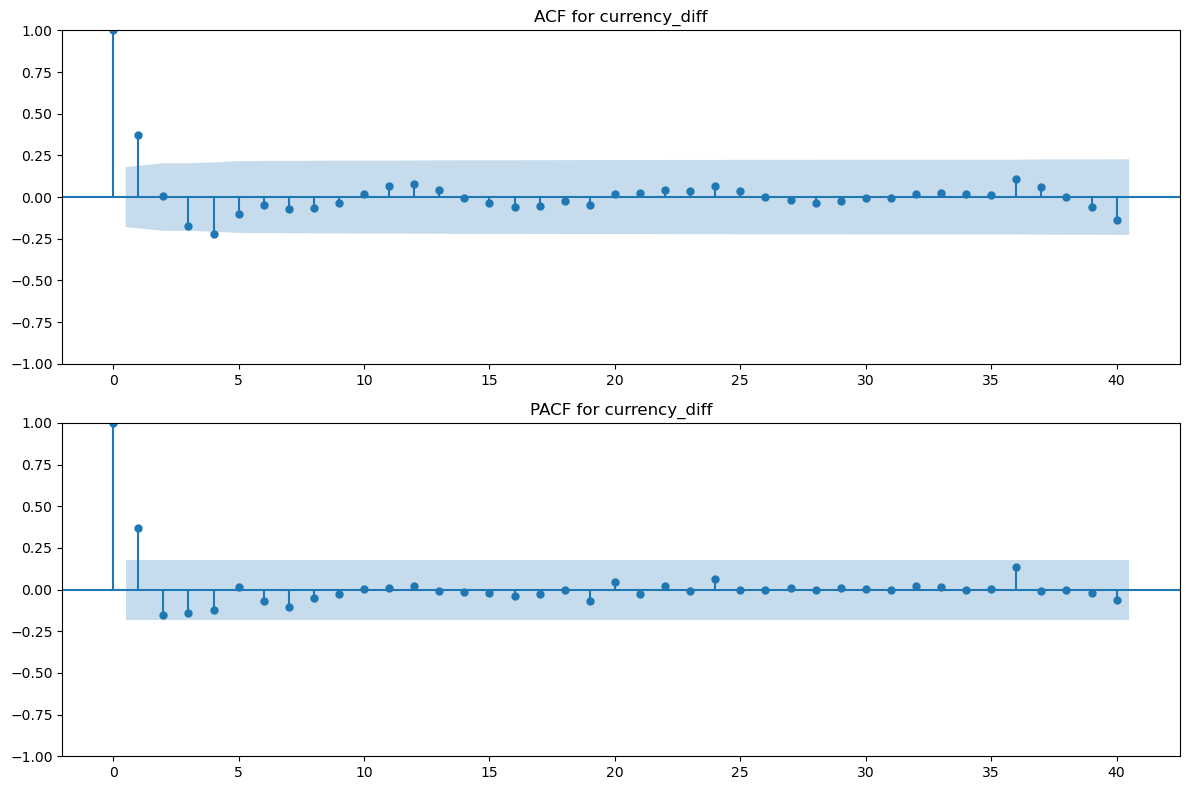

In [168]:
# ACF and PACF plots
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(series_to_use.dropna(), lags=40, ax=ax[0], title=f'ACF for {prefix}')
plot_pacf(series_to_use.dropna(), lags=40, ax=ax[1], title=f'PACF for {prefix}')
plt.tight_layout()
plt.show()

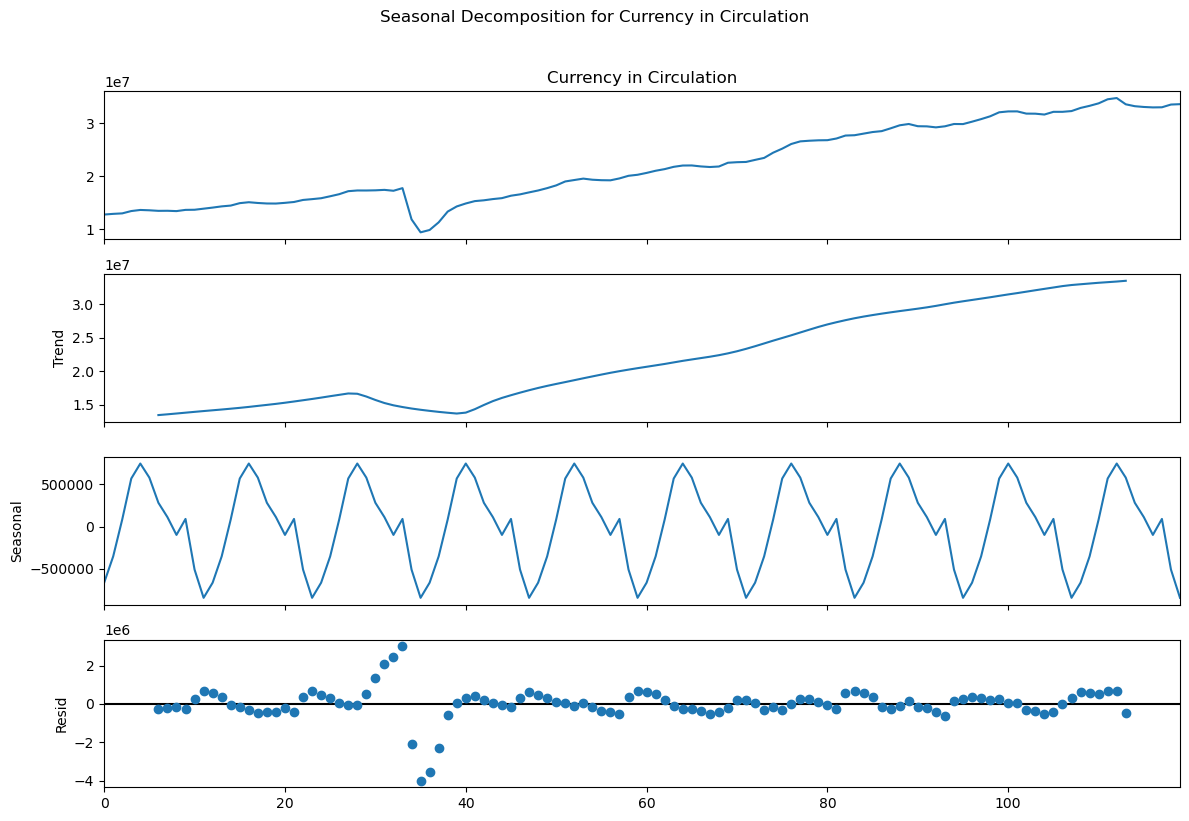

In [169]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['Currency in Circulation'].dropna(), model='additive', period=12)
fig = decomposition.plot()
fig.suptitle('Seasonal Decomposition for Currency in Circulation', y=1.02)
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()

# Model Selection and Fitting

In [170]:
# ARIMA Model without exogenous variables
order = (1, 0, 1)  # Start with simple order, can be modified based on ACF/PACF
model = SARIMAX(series_to_use.dropna(), order=order)
arima_results = model.fit(disp=False)
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:          Currency_diff   No. Observations:                  119
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1764.354
Date:                Mon, 28 Apr 2025   AIC                           3534.708
Time:                        21:06:59   BIC                           3543.045
Sample:                             0   HQIC                          3538.094
                                - 119                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2294      0.181      1.266      0.206      -0.126       0.585
ma.L1          0.2143      0.168      1.277      0.202      -0.115       0.543
sigma2      4.563e+11   5.27e-13   8.66e+23      0.0

/usr/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [171]:
# ARIMAX Model with exogenous variables
endog = df['Currency in Circulation']
exog = df[['Repo Rate', 'CPI Inflation Rate (in %)']]
exog = exog.fillna(method='bfill').fillna(method='ffill')
exog = sm.add_constant(exog)  # Add constant for intercept

# Try different orders and select based on AIC
orders = [(1,1,1), (1,0,1), (2,1,2)]
best_aic = np.inf
best_results = None

for order in orders:
    try:
        model = SARIMAX(endog,
                      exog=exog,
                      order=order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_results = results
            best_order = order
    except:
        continue

if best_results is None:
    raise ValueError("No suitable ARIMAX model could be fitted")

print(f'Best order: {best_order}')
print(f'Best AIC: {best_aic:.2f}')
print(best_results.summary())

Best order: (2, 1, 2)
Best AIC: 3452.93
                                  SARIMAX Results                                  
Dep. Variable:     Currency in Circulation   No. Observations:                  120
Model:                    SARIMAX(2, 1, 2)   Log Likelihood               -1718.463
Date:                     Mon, 28 Apr 2025   AIC                           3452.925
Time:                             21:06:59   BIC                           3474.954
Sample:                                  0   HQIC                          3461.868
                                     - 120                                         
Covariance Type:                       opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2.364e-09        nan        nan        nan         nan         nan
Repo R

/tmp/ipykernel_5624/258932921.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog = exog.fillna(method='bfill').fillna(method='ffill')


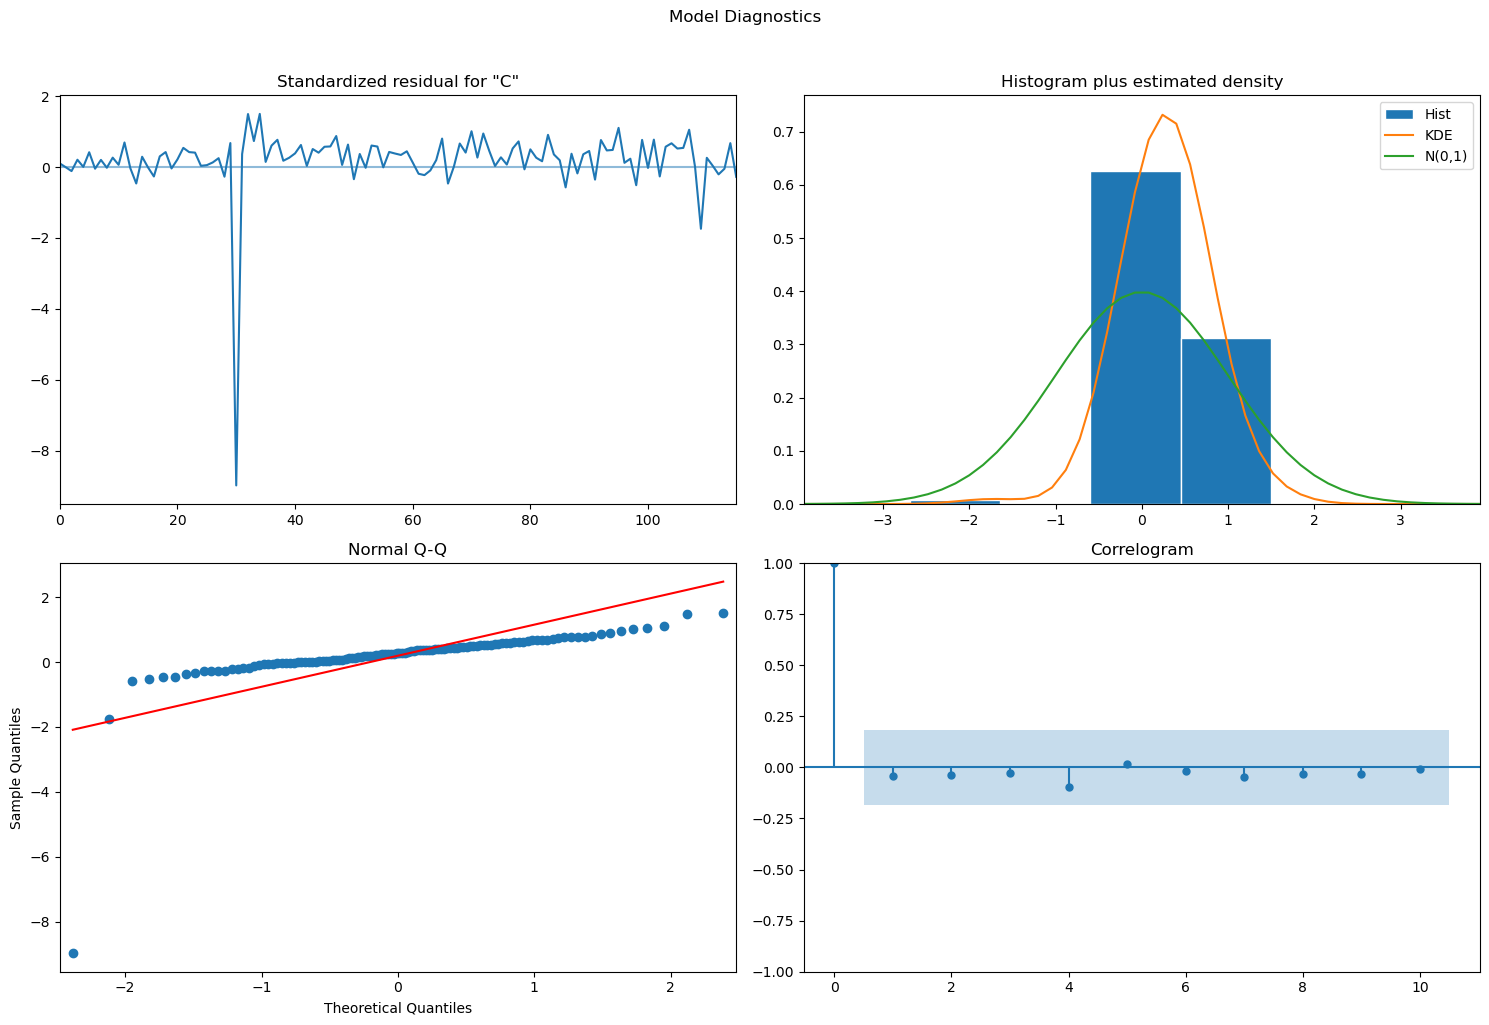

In [172]:
# Model Diagnostics
fig = best_results.plot_diagnostics(figsize=(15, 10))
fig.suptitle('Model Diagnostics', y=1.02)
plt.tight_layout()
plt.show()

# Model Diagnostics

In [173]:
# Ljung-Box Test
lb_test = acorr_ljungbox(best_results.resid, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(lb_test)

Ljung-Box Test:
      lb_stat  lb_pvalue
10  13.756753   0.184379


In [174]:
# Jarque-Bera Test
jb_test = jarque_bera(best_results.resid)
print("\nJarque-Bera Test:")
print(f"Test Statistic: {jb_test[0]}")
print(f"p-value: {jb_test[1]}")


Jarque-Bera Test:
Test Statistic: 18401.337818642234
p-value: 0.0


In [175]:
# ARCH Test
arch_test = het_arch(best_results.resid)
print("\nARCH Test:")
print(f"Test Statistic: {arch_test[0]}")
print(f"p-value: {arch_test[1]}")


ARCH Test:
Test Statistic: 0.15211014036152326
p-value: 0.9999999800951279


# Forecasting

In [176]:
def extrapolate_future_exog(df, exog_cols, steps):
    """Extrapolate future values for exogenous variables"""
    future_data = {}
    n = len(df)
    time_index = np.arange(n)

    for col in exog_cols:
        y = df[col].values
        X = sm.add_constant(time_index)
        model = sm.OLS(y, X).fit()
        
        future_time_index = np.arange(n, n + steps)
        X_future = sm.add_constant(future_time_index)
        
        future_vals = model.predict(X_future)
        future_data[col] = future_vals

    future_exog_df = pd.DataFrame(future_data)
    future_exog_df = sm.add_constant(future_exog_df)
    
    return future_exog_df

# Generate future exogenous variables
future_exog = extrapolate_future_exog(df, ['Repo Rate', 'CPI Inflation Rate (in %)'], forecast_steps)
print("Extrapolated future exogenous variables:")
print(future_exog)

Extrapolated future exogenous variables:
   const  Repo Rate  CPI Inflation Rate (in %)
0    1.0   4.509128                   5.852391
1    1.0   4.485126                   5.862385
2    1.0   4.461124                   5.872380
3    1.0   4.437122                   5.882375
4    1.0   4.413120                   5.892369


In [177]:
# Generate forecasts
forecast = best_results.get_forecast(steps=forecast_steps, exog=future_exog)
forecast_df = forecast.summary_frame()
print("\nForecast results:")
print(forecast_df)


Forecast results:
Currency in Circulation          mean       mean_se  mean_ci_lower  \
120                      3.460275e+07  6.715799e+05   3.328647e+07   
121                      3.456496e+07  1.184377e+06   3.224363e+07   
122                      3.453163e+07  1.580116e+06   3.143466e+07   
123                      3.451942e+07  1.865667e+06   3.086278e+07   
124                      3.452643e+07  2.075535e+06   3.045846e+07   

Currency in Circulation  mean_ci_upper  
120                       3.591902e+07  
121                       3.688630e+07  
122                       3.762860e+07  
123                       3.817606e+07  
124                       3.859441e+07  


/tmp/ipykernel_5624/675548197.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df['Month'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]


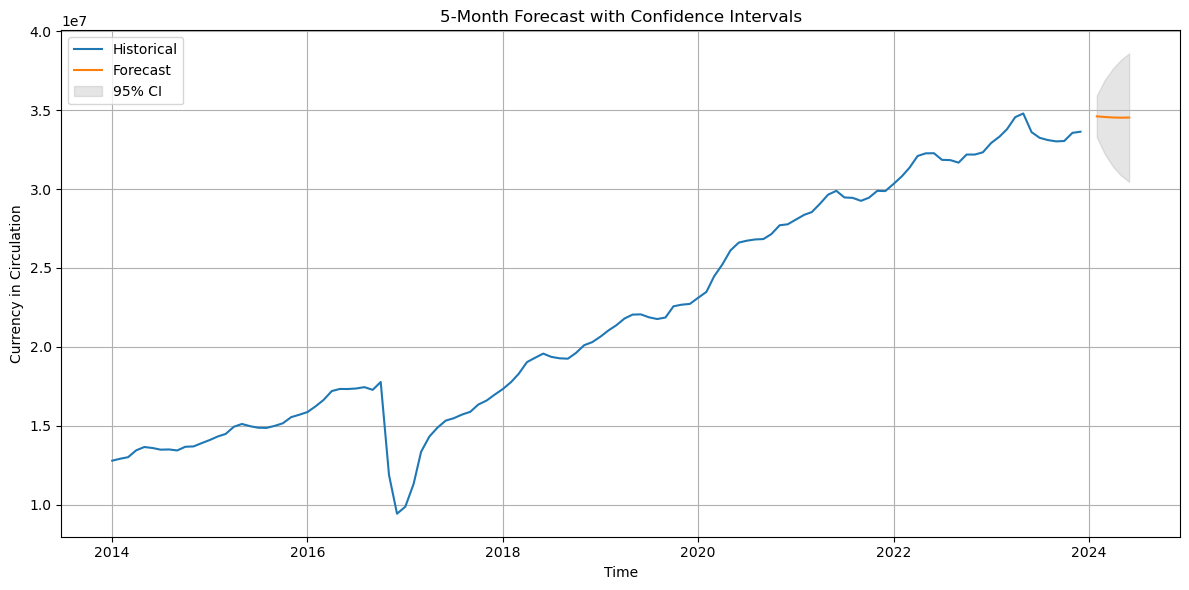

In [178]:
# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(df['Month'], df['Currency in Circulation'], label='Historical')
forecast_index = pd.date_range(start=df['Month'].iloc[-1], periods=forecast_steps+1, freq='M')[1:]
plt.plot(forecast_index, forecast_df['mean'], label='Forecast')
plt.fill_between(forecast_index,
                 forecast_df['mean_ci_lower'],
                 forecast_df['mean_ci_upper'],
                 color='gray', alpha=0.2, label='95% CI')
plt.title(f'{forecast_steps}-Month Forecast with Confidence Intervals')
plt.xlabel('Time')
plt.ylabel('Currency in Circulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()